In [5]:
import pandas as pd
import numpy as np

IMU_COLUMN_NAMES = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 've',
                    'vf', 'vl', 'vu', 'ax', 'ay',' az', 'af', 'al', 'au',
                    'wx', 'wy', 'wz', 'wf', 'wl', 'wu', 'posacc', 'velacc',
                    'navsats', 'numsats','posmode', 'velmode', 'orimode']

def read_imu(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = IMU_COLUMN_NAMES
    return df

In [6]:
read_imu('/home/xilm/fuxian/auto_drive_kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000000.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navsats,numsats,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


In [7]:
read_imu('/home/xilm/fuxian/auto_drive_kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000001.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navsats,numsats,posmode,velmode,orimode
0,49.01121,8.422887,112.846901,0.022857,0.004342,-1.206077,-3.288107,1.166745,3.488639,0.054704,...,-0.004166,0.044282,0.139954,0.492294,0.068884,4,10,4,4,0


In [8]:
def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great circle distance from two gps data
    Input: latitudes and longitudes in degree
    Output: distance in meter
    """
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0 * np.arccos(np.clip(delta_sigma, -1, 1))

In [12]:
prev_imu_data = None
gps_distance = []
imu_distance = []
for frame in range(150):
    imu_data = read_imu('/home/xilm/fuxian/auto_drive_kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    if prev_imu_data is not None:
        gps_distance += [compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon)]
        imu_distance += [0.1 * np.linalg.norm(imu_data[['vf', 'vl']])]

    prev_imu_data = imu_data

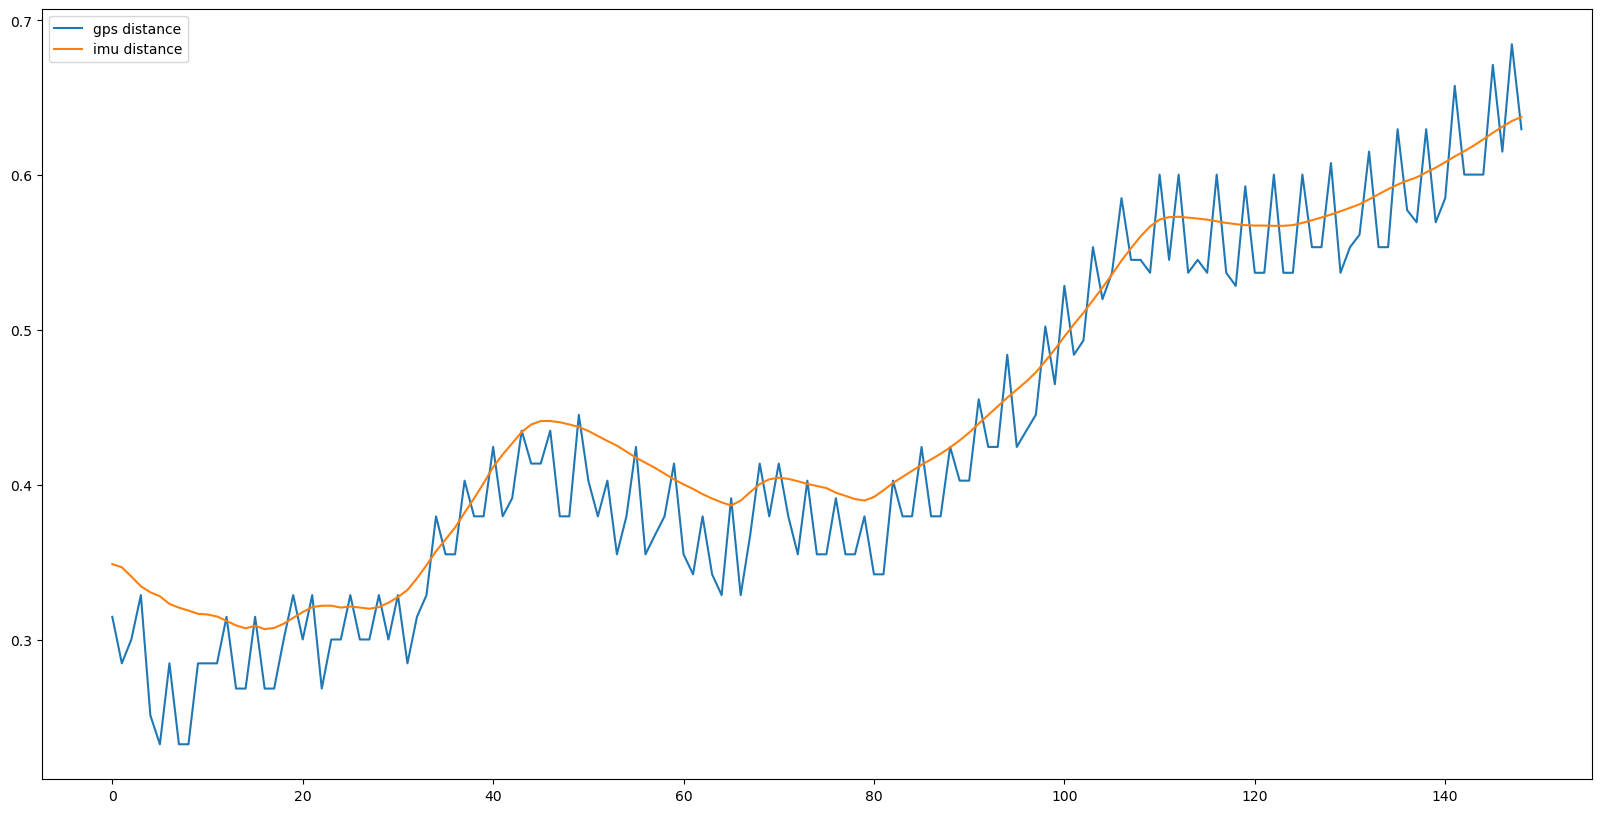

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(gps_distance, label='gps distance')
plt.plot(imu_distance, label='imu distance')
plt.legend()
plt.show()

In [15]:
prev_imu_data = None
locations = []

for frame in range(150):
    imu_data = read_imu('/home/xilm/fuxian/auto_drive_kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)

    if prev_imu_data is not None:
        displacement = 0.1 * np.linalg.norm(imu_data[['vf', 'vl']])
        yaw_change = float(imu_data.yaw - prev_imu_data.yaw)
        for i in range(len(locations)):
            x0, y0 = locations[i]
            x1 = x0 * np.cos(yaw_change) + y0 * np.sin(yaw_change) - displacement
            y1 = -x0 * np.sin(yaw_change) + y0 * np.cos(yaw_change)
            locations[i] = np.array([x1, y1])

    locations += [np.array([0, 0])]
    prev_imu_data = imu_data

In [16]:
locations

[array([-55.24572559, -24.47145956]),
 array([-54.91022885, -24.37565838]),
 array([-54.57791154, -24.2762731 ]),
 array([-54.25259246, -24.17455335]),
 array([-53.93467008, -24.07025329]),
 array([-53.62178149, -23.9632472 ]),
 array([-53.31267038, -23.85318867]),
 array([-53.00965276, -23.7407106 ]),
 array([-52.71024957, -23.62560908]),
 array([-52.41393101, -23.50778036]),
 array([-52.12104176, -23.38704771]),
 array([-51.83003203, -23.26301029]),
 array([-51.54159505, -23.13623635]),
 array([-51.25733272, -23.00707816]),
 array([-50.97727257, -22.8758063 ]),
 array([-50.70047752, -22.74209154]),
 array([-50.42371113, -22.6043504 ]),
 array([-50.15043211, -22.46467719]),
 array([-49.87804408, -22.32164603]),
 array([-49.60491985, -22.17415692]),
 array([-49.33049748, -22.02124706]),
 array([-49.05459044, -21.86323255]),
 array([-48.77803817, -21.7000015 ]),
 array([-48.50269966, -21.53302798]),
 array([-48.22929814, -21.36281905]),
 array([-47.9588139 , -21.19027525]),
 array([-47.

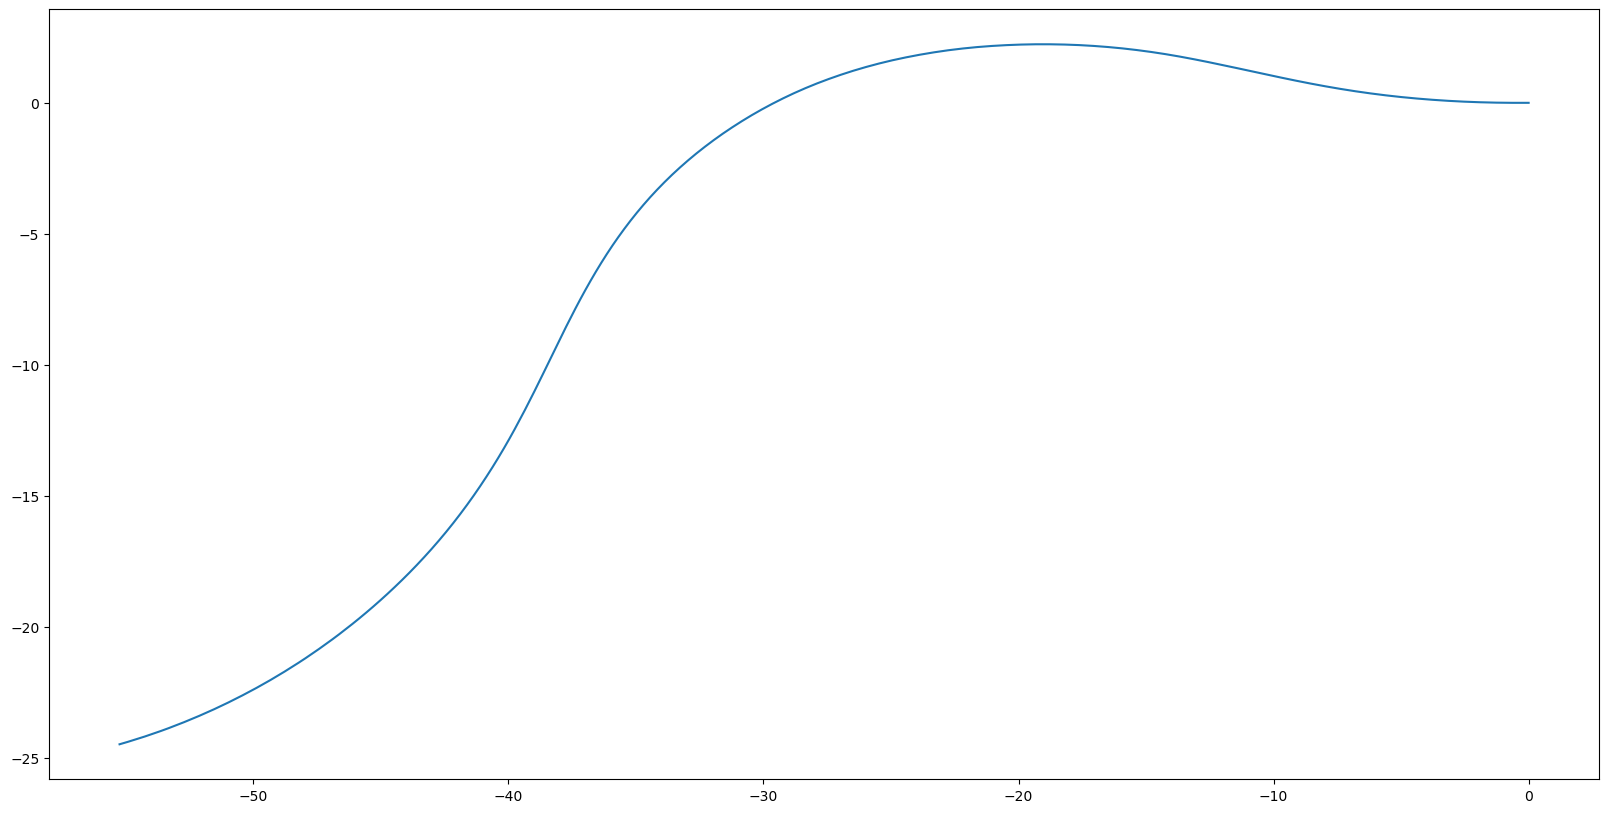

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(np.array(locations)[:, 0], np.array(locations)[:, 1]) # x coordinate and y coordinate